# 7 - Working with Plate Tectonic Stats
In this notebook, we will look at GPlately methods to obtain certain plate tectonic stats such as:
- The total lengths of ridges, trenches and transforms
- Mean spreading and convergence rates with uncertainties
- Crustal surface areas produced and destroyed over 1 year

and we will compare different plate models' stats with plots.

First, let's load our modules:

In [10]:
import gplately
import numpy as np
import pygplates
import ptt
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

For this notebook, we'll use the Muller2019 plate reconstruction model. Let's create the `model` with GPlately: 

In [2]:
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

.gpml static files were not found. Attempting to find .shp versions instead...
Found a static file with a .shp extension.


## Defining a plate model stats function
Below we define a function that takes a GPlately `PlateReconstruction` object, resolves its topologies and obtains the:
- Total length of all mid-ocean ridges (km)
- Mean ridge spreading velocity (spreading rate) (cm/yr)
- Mean ridge spreading velocity standard deviation (cm/yr)
- Crustal surface area produced over 1 yr at ridges (km^2/yr)
- Total length of all subduction zones (km)
- Mean subduction velocity (convergence rate) (cm/yr)
- Mean subduction velocity standard deviation (cm/yr)
- Crustal surface area subducted by trenches over 1 yr (km^2/yr)
- Length of all transform boundaries (km)

Let's obtain the plate tectonic stats for the Muller et al. 2019 model.

In [71]:
# Function to obtain plate tectonic stats at a specified reconstruction time
def get_plate_tectonic_stats(model, reconstruction_time):

    # Obtain plate tectonic stats as an array for the current geological time.    
    print('Obtaining plate tectonic stats for:', reconstruction_time, 'Ma')

    # Function to calculate Earth radius at a particular latitude
    def get_earth_radius_km(trench_pt_lat): 
        rlat = np.radians(trench_pt_lat)
        coslat = np.cos(rlat)
        sinlat = np.sin(rlat)
        r1 = 6384.4e3
        r2 = 6352.8e3
        num = (r1**2*coslat)**2 + (r2**2*sinlat)**2
        den = (r1*coslat)**2 + (r2*sinlat)**2
        earth_radius = np.sqrt(num/den)/1000
        return earth_radius

    # Create topological plate polygons
    boundary_features = ptt.resolve_topologies.resolve_topologies_into_features(
        rotation_model, topology_features, reconstruction_time)
    boundary_features = list(boundary_features)
    boundary_features.pop(0)
    len_ridge_transform, len_ridge, len_transform, len_subd, len_subd_l, len_subd_r, len_other =  \
        ptt.resolve_topologies.find_total_boundary_length_in_kms(*boundary_features)

    # Calculate ridge stats
    ridge_data = model.tesselate_mid_ocean_ridges(reconstruction_time)
    ridge_data = ridge_data[ridge_data[:,2] >= 0]
    ridge_lon, ridge_lat = ridge_data[:,0], ridge_data[:,1]
    ridge_vel = ridge_data[:,2]*1e-2 # m/yr
    ridge_len = []
    for i, segment in enumerate(ridge_data[:,3]):
        ridge_len.append(np.radians(segment) * get_earth_radius_km(ridge_data[i,1]))
    ridge_vel_mean, ridge_vel_std = np.mean(ridge_vel), np.std(ridge_vel)
    ridge_surface_area = np.sum(ridge_vel * ridge_len)


    # Calculate subduction convergence stats
    subduction_data = model.tesselate_subduction_zones(reconstruction_time)
    subduction_lon, subduction_lat = subduction_data[:,0], subduction_data[:,1]
    subduction_len = []
    for i, segment in enumerate(subduction_data[:,6]):
        subduction_len.append(np.radians(segment) * get_earth_radius_km(subduction_data[i,1]))

    # protect against "negative" subduction
    subduction_data[:,2] = np.clip(subduction_data[:,2], 0.0, 1e99)
    subduction_vel = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))
    subd_vel_mean, subd_vel_std = np.mean(subduction_vel), np.std(subduction_vel)

    # area subducted by trenches over 1 yr
    subd_surface_area = np.sum(subduction_vel * subduction_len)

    # Format units
    len_ridge      = len_ridge * 1e-3 # m to km
    ridge_vel_mean     = ridge_vel_mean * 100  # m/yr to cm/yr
    ridge_vel_std      = ridge_vel_std * 100  # m/yr to cm/yr
    ridge_surface_area = ridge_surface_area * 1e-6 # m^2/a to km^2/a
    len_subd       = len_subd * 1e-3 # m to km
    subd_vel_mean      = subd_vel_mean * 100  # m/yr to cm/yr
    subd_vel_std       = subd_vel_std * 100  # m/yr to cm/yr
    subd_surface_area  = subd_surface_area * 1e-6 # m^2 /a to km^2/a
    len_transform  = len_transform * 1e-3 # m to km

    # Append all obtained attributes into a 1D numpy array.
    data_for_this_reconstruction_time = np.array([int(reconstruction_time), len_ridge, ridge_vel_mean, ridge_vel_std, \
                                                  ridge_surface_area, len_subd,  subd_vel_mean,   subd_vel_std, \
                                                  subd_surface_area, len_transform])

    if len(data_for_this_reconstruction_time) == 0:
            print("No data obtained for %i Ma" %time)

    return data_for_this_reconstruction_time

Let's obtain Muller2019 plate tectonic stats from 0-50Ma.

In [101]:
# Set our time array
time_array = np.arange(0,51)

data_array = []
for time in time_array:
# Get plate tectonic stats
    data_array.append(get_plate_tectonic_stats(model, time))

Obtaining plate tectonic stats for: 0 Ma
Obtaining plate tectonic stats for: 1 Ma
Obtaining plate tectonic stats for: 2 Ma
Obtaining plate tectonic stats for: 3 Ma
Obtaining plate tectonic stats for: 4 Ma
Obtaining plate tectonic stats for: 5 Ma
Obtaining plate tectonic stats for: 6 Ma
Obtaining plate tectonic stats for: 7 Ma
Obtaining plate tectonic stats for: 8 Ma
Obtaining plate tectonic stats for: 9 Ma
Obtaining plate tectonic stats for: 10 Ma
Obtaining plate tectonic stats for: 11 Ma
Obtaining plate tectonic stats for: 12 Ma
Obtaining plate tectonic stats for: 13 Ma
Obtaining plate tectonic stats for: 14 Ma
Obtaining plate tectonic stats for: 15 Ma
Obtaining plate tectonic stats for: 16 Ma
Obtaining plate tectonic stats for: 17 Ma
Obtaining plate tectonic stats for: 18 Ma
Obtaining plate tectonic stats for: 19 Ma
Obtaining plate tectonic stats for: 20 Ma
Obtaining plate tectonic stats for: 21 Ma
Obtaining plate tectonic stats for: 22 Ma
Obtaining plate tectonic stats for: 23 Ma
Ob

## Visualising plate tectonic stats from arrays
As an example, let's plot the ridge spreading rate and trench convergence rate as a function of time.

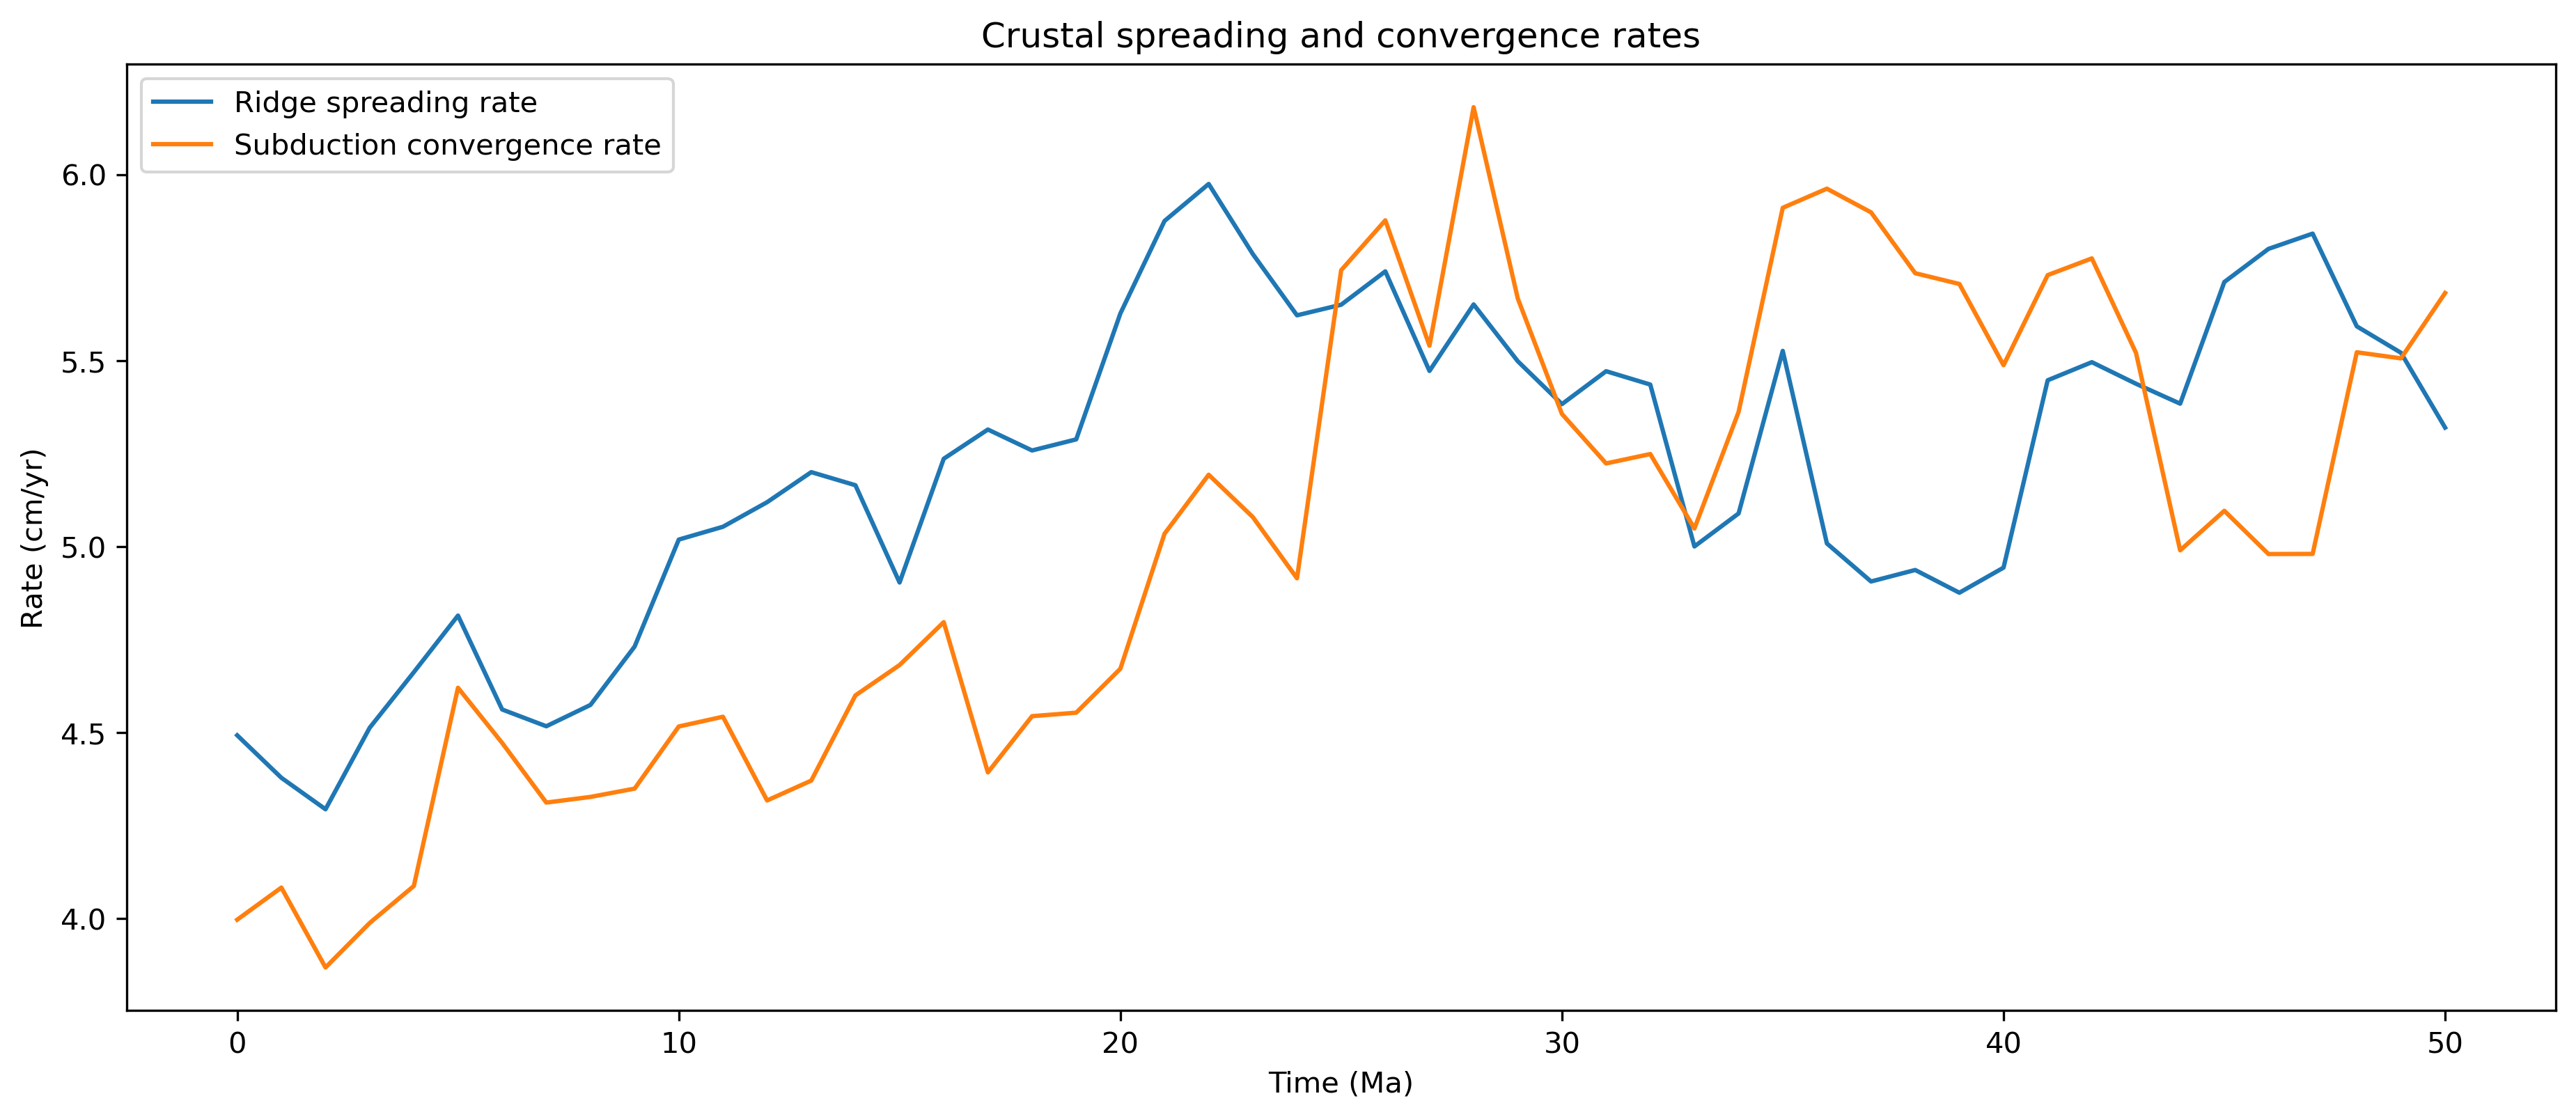

In [117]:
# Get the data into individual arrays
reconst_time = [int(time[0]) for time in data_array]
tot_ridge_length = [length[1] for length in data_array]
spreading_rate = [rate[2] for rate in data_array]
spreading_rate_sd = [rate_sd[3] for rate_sd in data_array]
crust_produced = [area[4] for area in data_array]
tot_sz_length = [length[5] for length in data_array]
convergence_rate = [rate[6] for rate in data_array]
convergence_rate_sd = [rate_sd[7] for rate_sd in data_array]
crust_destroyed = [area[8] for area in data_array]
tot_transform_length = [length[9] for length in data_array]

# Plot 
plt.figure(figsize=(15, 6), dpi=300)
plt.plot(reconst_time, spreading_rate, label="Ridge spreading rate")
plt.plot(reconst_time, convergence_rate, label="Subduction convergence rate")     
plt.title("Crustal spreading and convergence rates")
plt.ylabel("Rate (cm/yr)") 
plt.xlabel("Time (Ma)")
plt.legend(loc="upper left")

## Creating CSV files of plate tectonic stats
Below is a way to collate all obtained plate tectonic stats arrays into a csv file.

In [92]:
# get the data into individual arrays
reconst_time = [int(time[0]) for time in data_array]
tot_ridge_length = [length[1] for length in data_array]
spreading_rate = [rate[2] for rate in data_array]
spreading_rate_sd = [rate_sd[3] for rate_sd in data_array]
crust_produced = [area[4] for area in data_array]
tot_sz_length = [length[5] for length in data_array]
convergence_rate = [rate[6] for rate in data_array]
convergence_rate_sd = [rate_sd[7] for rate_sd in data_array]
crust_destroyed = [area[8] for area in data_array]
tot_transform_length = [length[9] for length in data_array]

# Processing for CSV format
# time_array_int = [int(item) for item in reconst_time]
np.set_printoptions(suppress=True)
data_for_csv = np.column_stack((reconst_time, tot_ridge_length, spreading_rate, spreading_rate_sd,
                               crust_produced, tot_sz_length, convergence_rate, convergence_rate_sd, crust_destroyed,
                               tot_transform_length))
import csv
csv_directory = "./NotebookFiles/Muller2019_PlateTectonicStats_0-50_Ma.csv"
# open the file in the write mode
with open(csv_directory, 'w', encoding='UTF8', newline='') as f:
    # create the csv writer
    writer = csv.writer(f)
    writer.writerow(['Time (Ma)', 'Total ridge length (km)', 'Mean ridge spreading rate (cm/yr)', 
                     'Mean ridge spreading rate SD (cm/yr)', 'Crustal formation rate (km^2/yr)',
                     'Total subduction zone length (km)', 'Mean trench convergence rate (cm/yr)',
                     'Mean trench convergence rate SD (cm/year)', 'Crustal subduction rate (km^2/yr)',
                     'Total transform length (km)'])
    # write a row to the csv file
    writer.writerows(data_for_csv)
    
print('CSV file saved to specified directory. Returned array of plate tectonic stats.')

CSV file saved to specified directory. Returned array of plate tectonic stats.


## Visualising plate tectonics stats from CSV files
It is often useful to visualise the obtained plate tectonic stats of different plate reconstruction models. Let's look at stats for three of them:

1. Muller et al. 2019
2. Merdith 2021
3. EarthByte TRUNK Plate Motion Model

The paths to these stats csv files are in the NotebookFiles directory, provided below:

In [284]:
# CSV file directories
Merdith2021_stats = "./NotebookFiles/plate_tectonic_stats_Merdith2021-0-249Ma.csv"
Muller2019_stats = "./NotebookFiles/plate_tectonic_stats_Muller2019_0-249.csv"
TRUNK2021_stats = "./NotebookFiles/plate_tectonic_stats_TRUNK_0-249.csv"
directories = [Muller2019_stats, TRUNK2021_stats, Merdith2021_stats]

# A function to extract plate tectonic stats from the csv files defined above
def extract_stats_from_csv(directory):
    with open(directory) as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        csv_plate_tectonic_stats = []
        for row in csvreader:
            csv_plate_tectonic_stats.append(row)
        reconst_time = [int(float(time[0])) for time in csv_plate_tectonic_stats]
        tot_ridge_length = [length[1] for length in csv_plate_tectonic_stats]
        spreading_rate = [rate[2] for rate in csv_plate_tectonic_stats]
        spreading_rate_sd = [rate_sd[3] for rate_sd in csv_plate_tectonic_stats]
        crust_produced = [area[4] for area in csv_plate_tectonic_stats]
        tot_sz_length = [length[5] for length in csv_plate_tectonic_stats]
        convergence_rate = [rate[6] for rate in csv_plate_tectonic_stats]
        convergence_rate_sd = [rate_sd[7] for rate_sd in csv_plate_tectonic_stats]
        crust_destroyed = [area[8] for area in csv_plate_tectonic_stats]
        tot_transform_length = [length[9] for length in csv_plate_tectonic_stats]
        
        return(reconst_time, tot_ridge_length, spreading_rate, spreading_rate_sd, crust_produced,
              tot_sz_length, convergence_rate, convergence_rate_sd, crust_destroyed, tot_transform_length)
    
# Obtain stats for each plate motion model
Muller_stats = extract_stats_from_csv(directories[0])
TRUNK_stats = extract_stats_from_csv(directories[1])
Merdith_stats = extract_stats_from_csv(directories[2])
all_stats = np.array([Muller_stats, TRUNK_stats, Merdith_stats])

model_labels = {"0": "Muller 2019",
               "1" : "TRUNK Model",
               "2" : "Merdith 2021"}

In particular, let's look at the subduction zone length at each Ma, which is the 5th (starting count from 0) set of stats.

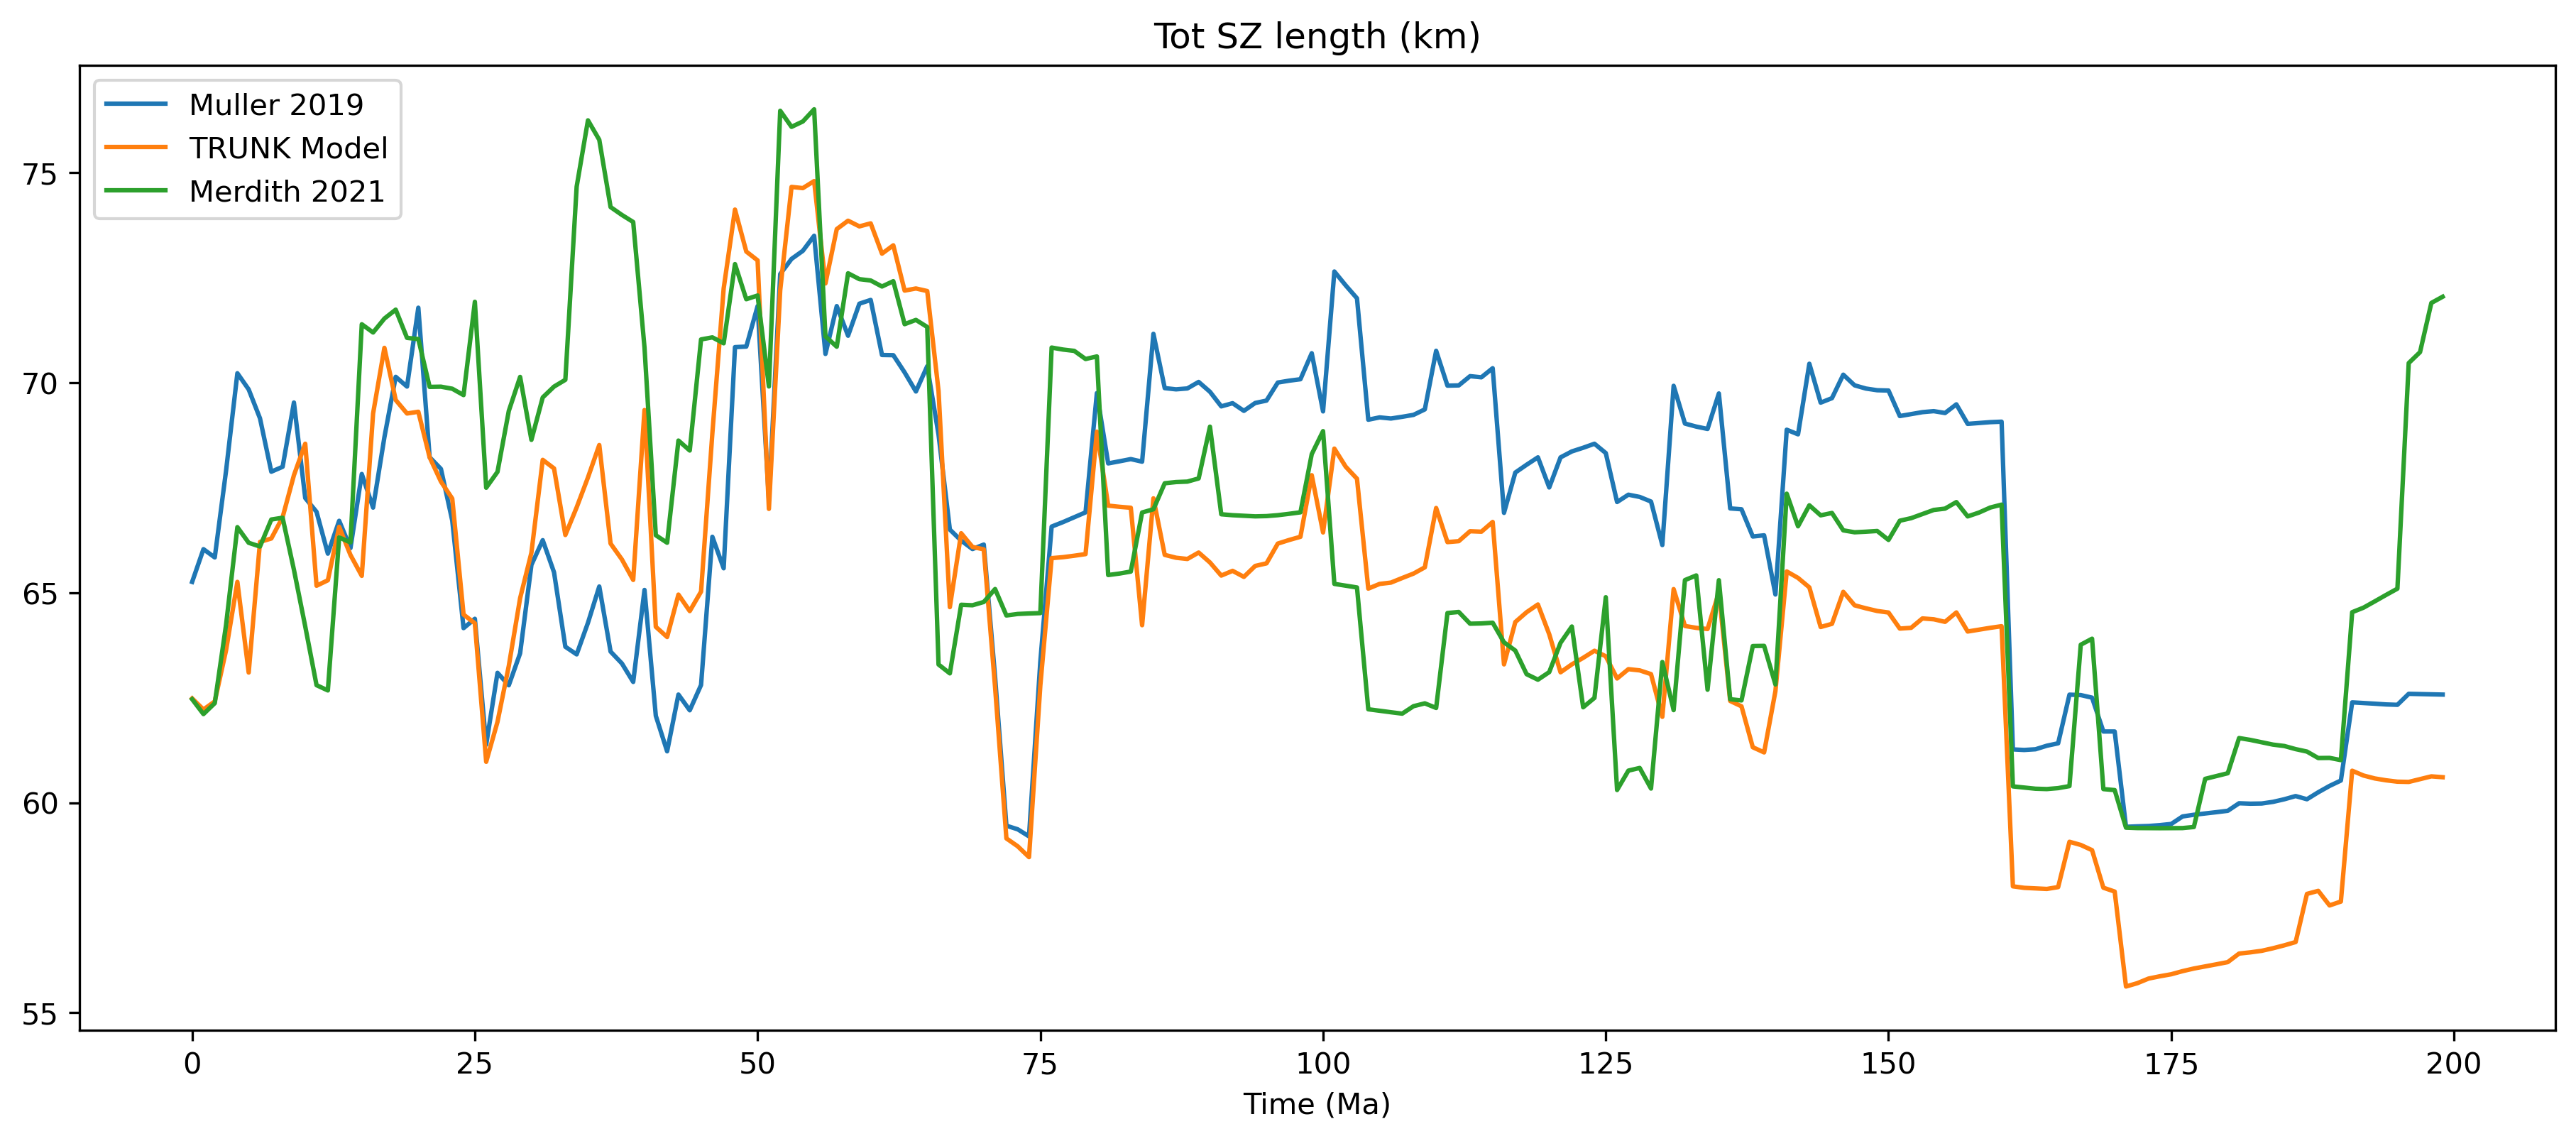

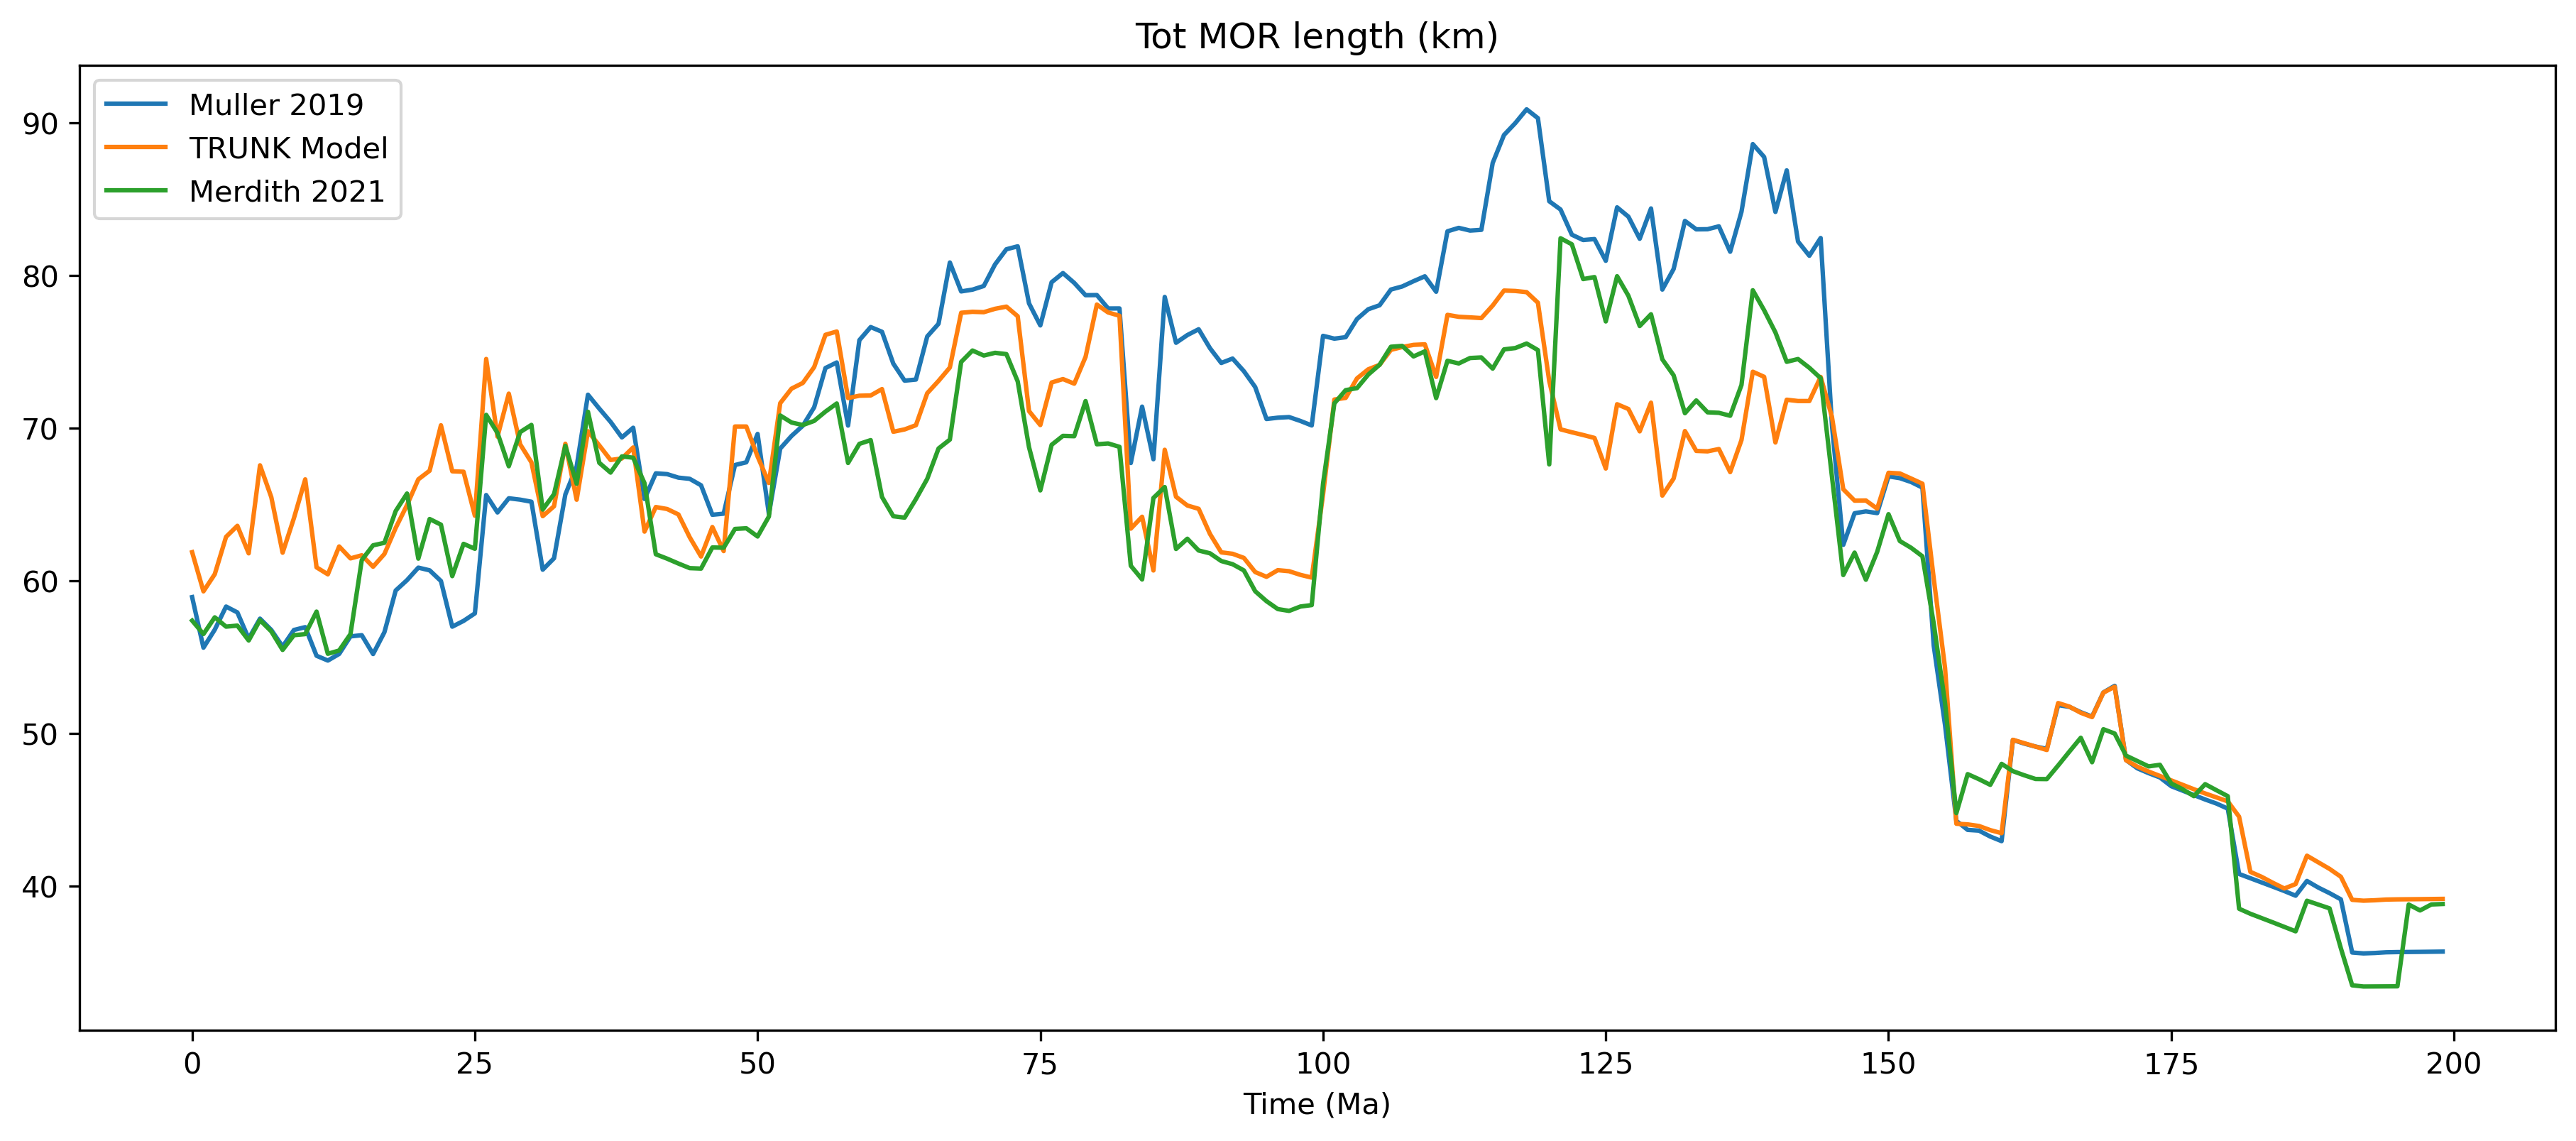

In [294]:
# Useful stat identifier dictionary
plot_properties = {"1": "Tot MOR length (km)",
                  "2": "Spreading rate (cm/yr)",
                  "3": "Spreading rate SD (cm/yr)",
                  "4": "Crust produced (km^2/yr)",
                  "5": "Tot SZ length (km)",
                  "6": "Mean convergence rate (cm/yr)",
                  "7": "Convergence rate SD (cm/yr) ",
                  "8": "Crust subducted (km^2/yr)",
                  "9": "Tot transform length (km)"
                  }

# Function for plotting the ith plate tectonic stat (where i can be from 1-9 as shown above)
def plot_ith_plate_tectonic_stat(all_stats, i, min_time, max_time, delta_time=1, save_loc=None):
    """ Plot the ith plate tectonic stat calculated for each of the plate model stats in `all_stats`
    
    Parameters
    ----------
    all_stats : array
        An array containing all paths to csv files containing plate tectonic stats for different plate motion models.
    i : int
        An integer from 1-9 to identify which stat to plot.
    min_time : int
        Starting time to plot from.
    max_time : int
        Last time to plot from.
    delta_time : int, default=1
        Time interval for plotting; by default every 1 Ma.
    save_loc : str, default=None
        Optional: a directory including a filename + filetype extension to save plots to.
    """
    plt.figure(figsize=(15, 6), dpi=300)
    for model_i, stats in enumerate(all_stats):
        stats_to_plot = [float(str(stat)) for stat in stats[i][min_time:max_time:delta_time]]
        time_to_plot = [int(str(time)) for time in stats[0][min_time:max_time:delta_time]]
        plt.plot(time_to_plot, stats_to_plot, label=model_labels[str(model_i)])   
    
    plt.title(plot_properties[str(i)]) 
    plt.xlabel("Time (Ma)")
    plt.legend(loc="upper left")
    
    if save_loc is not None:
        plt.savefig(save_loc, dpi=300)
    

# Plot the 5th and 1st stats: total subduction zone and MOR length (km) for all three plate models from 0-200Ma
min_time = 0
max_time = 200
indices = [5, 1]
for i in indices:
    plot_ith_plate_tectonic_stat(all_stats, i, min_time, max_time)

## Plotting differences between plate model stats
Another useful type of plot shows the difference between two (or more) plate models' plate tectonic stats. For this notebook, let's look again at total subduction zone lengths and how they differ among plate models.

The function below compares only 2 plate tectonic stats csv files, but it can be used for different file combinations for >2 models. 

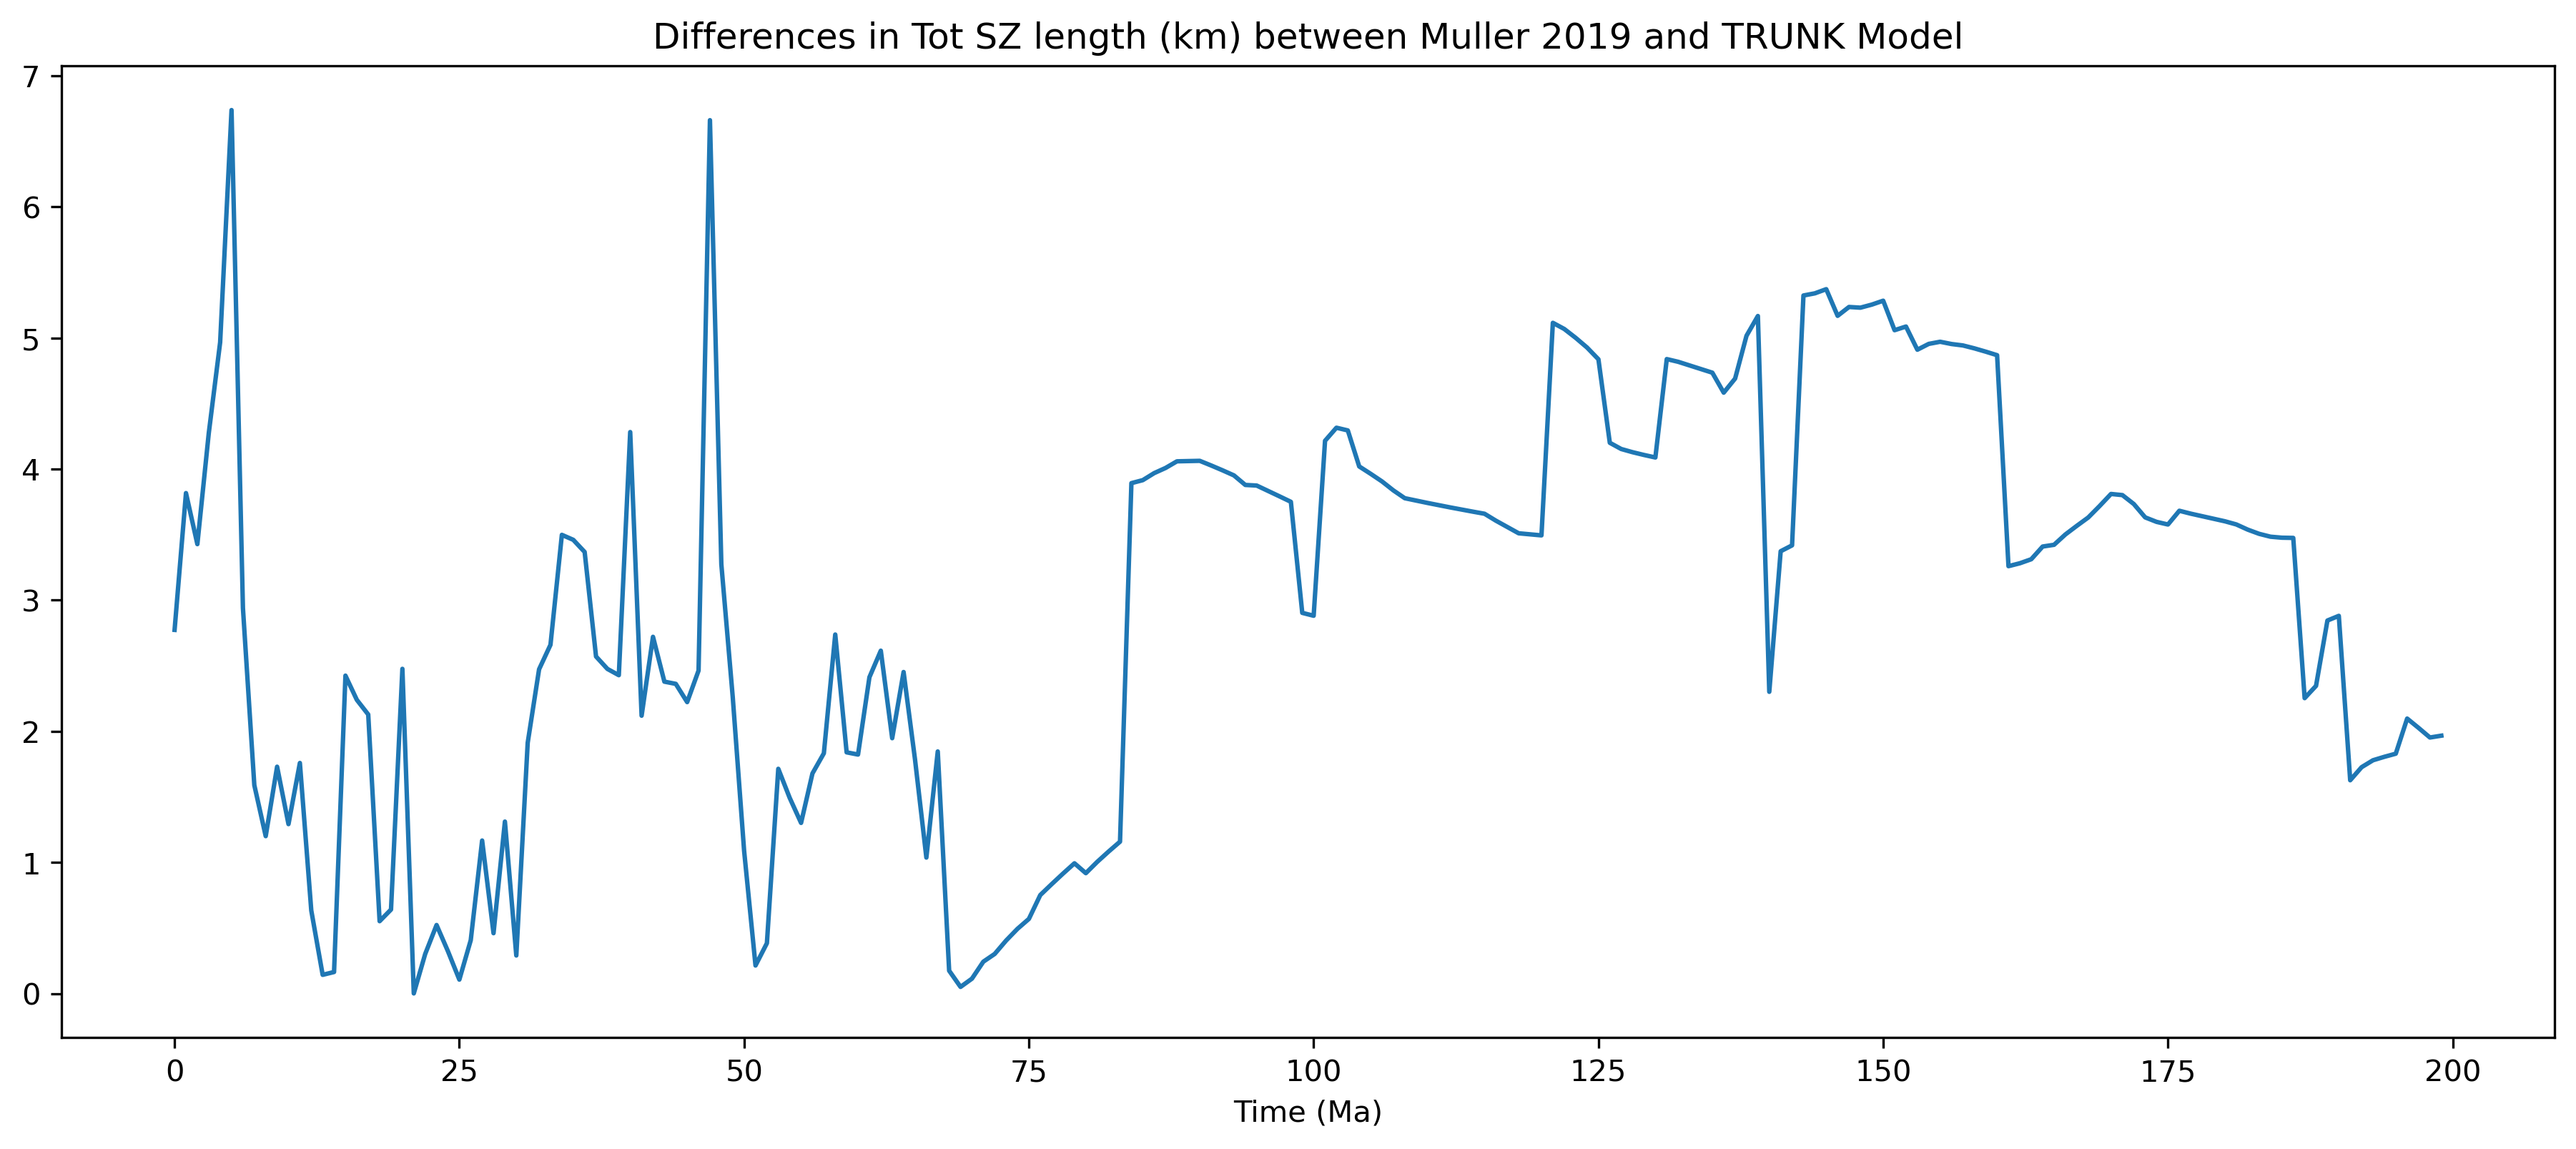

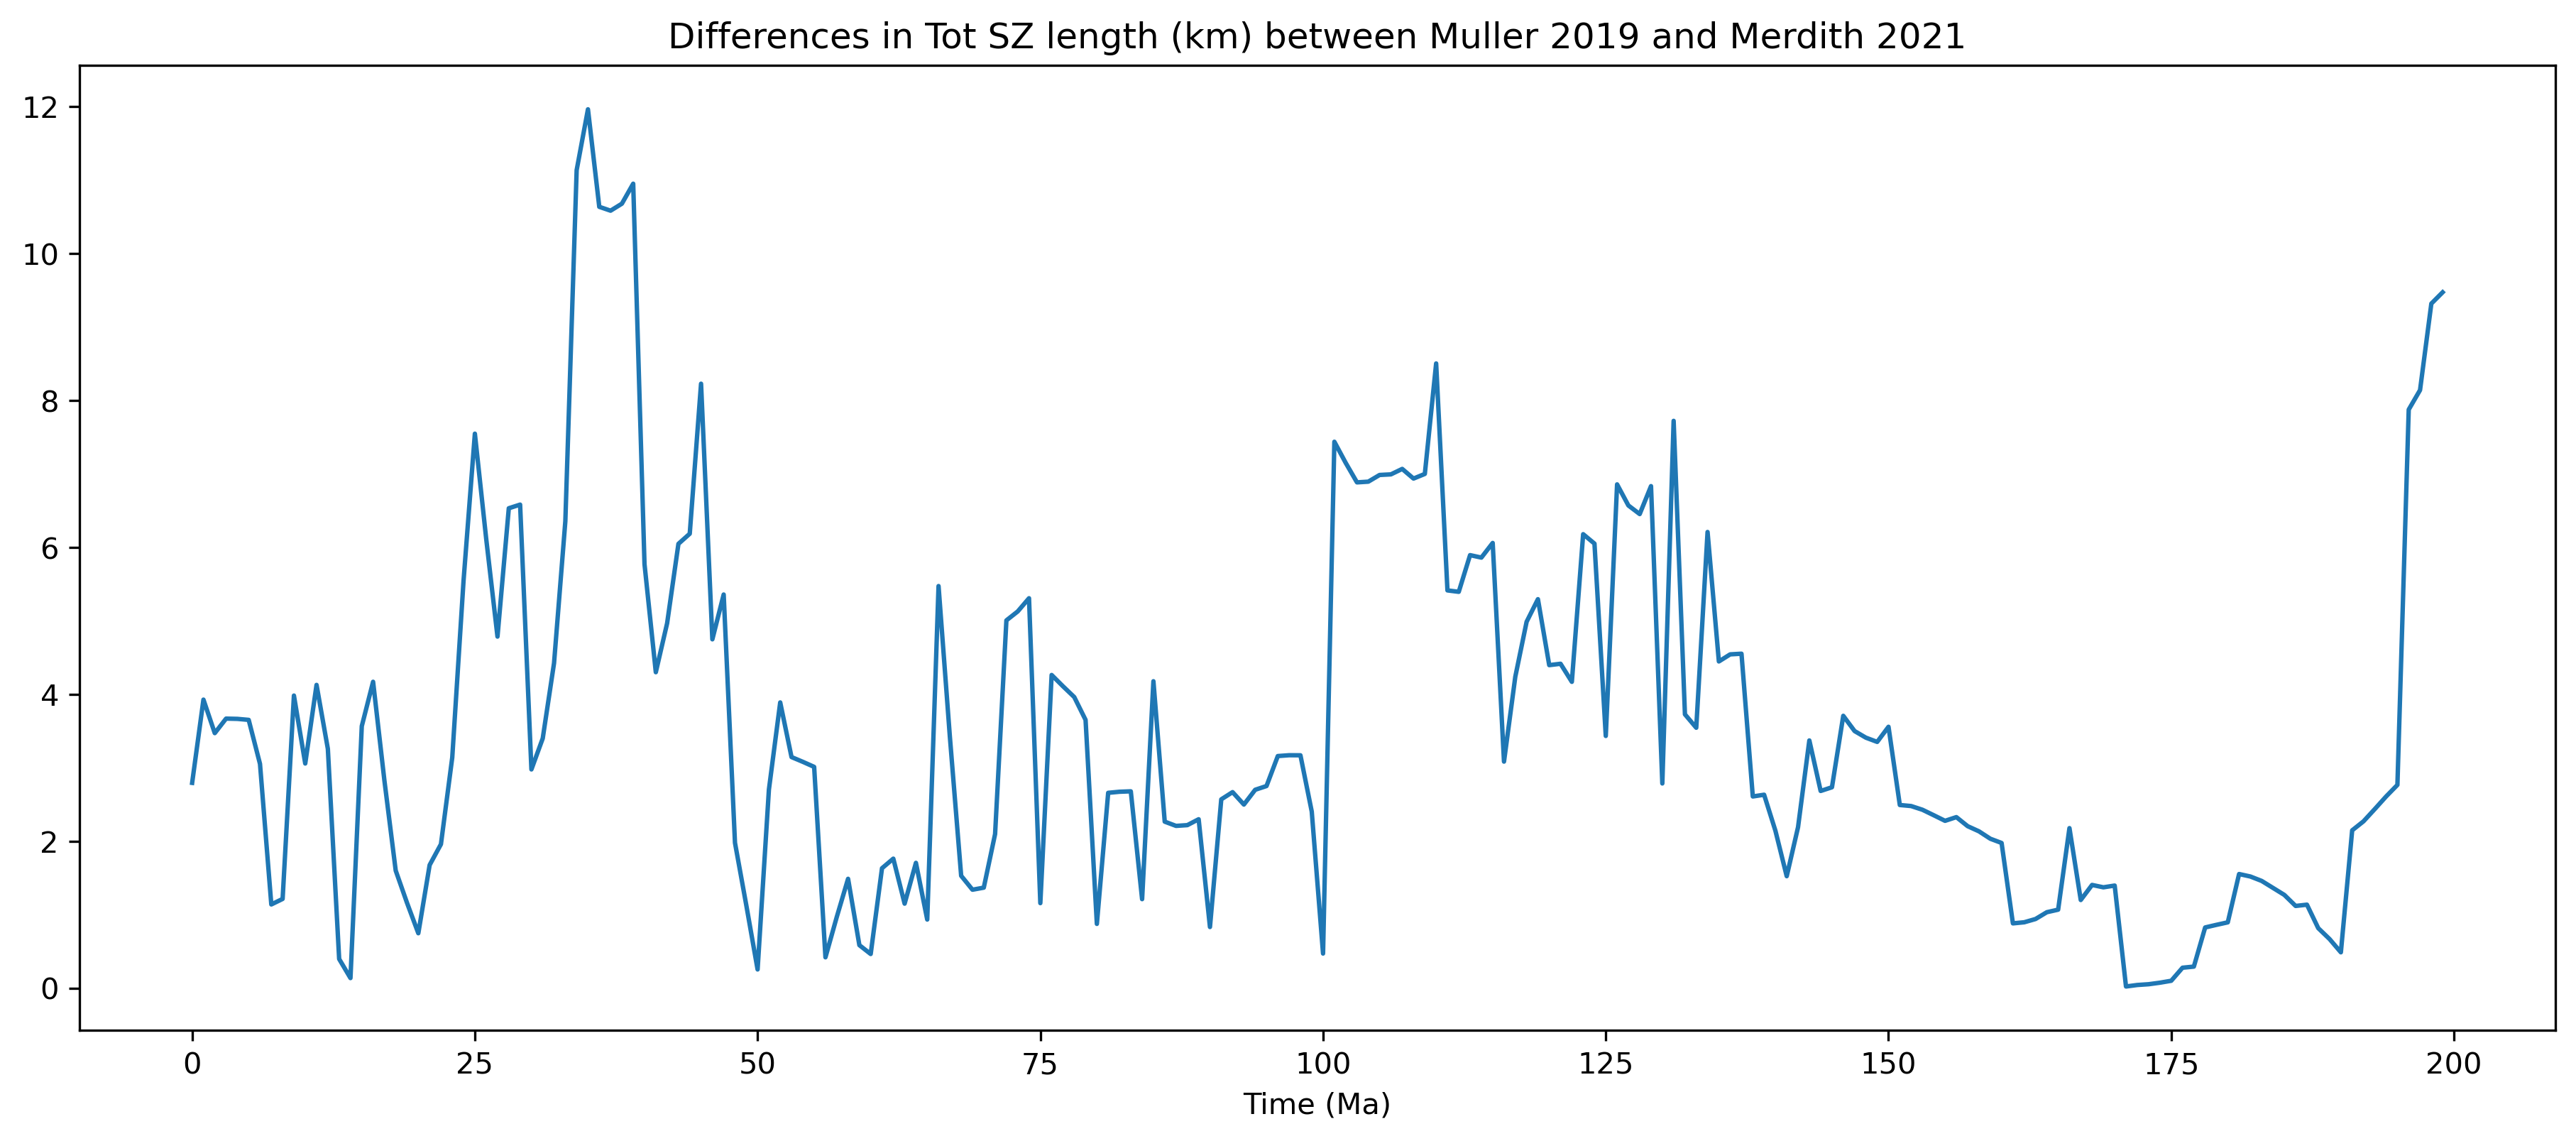

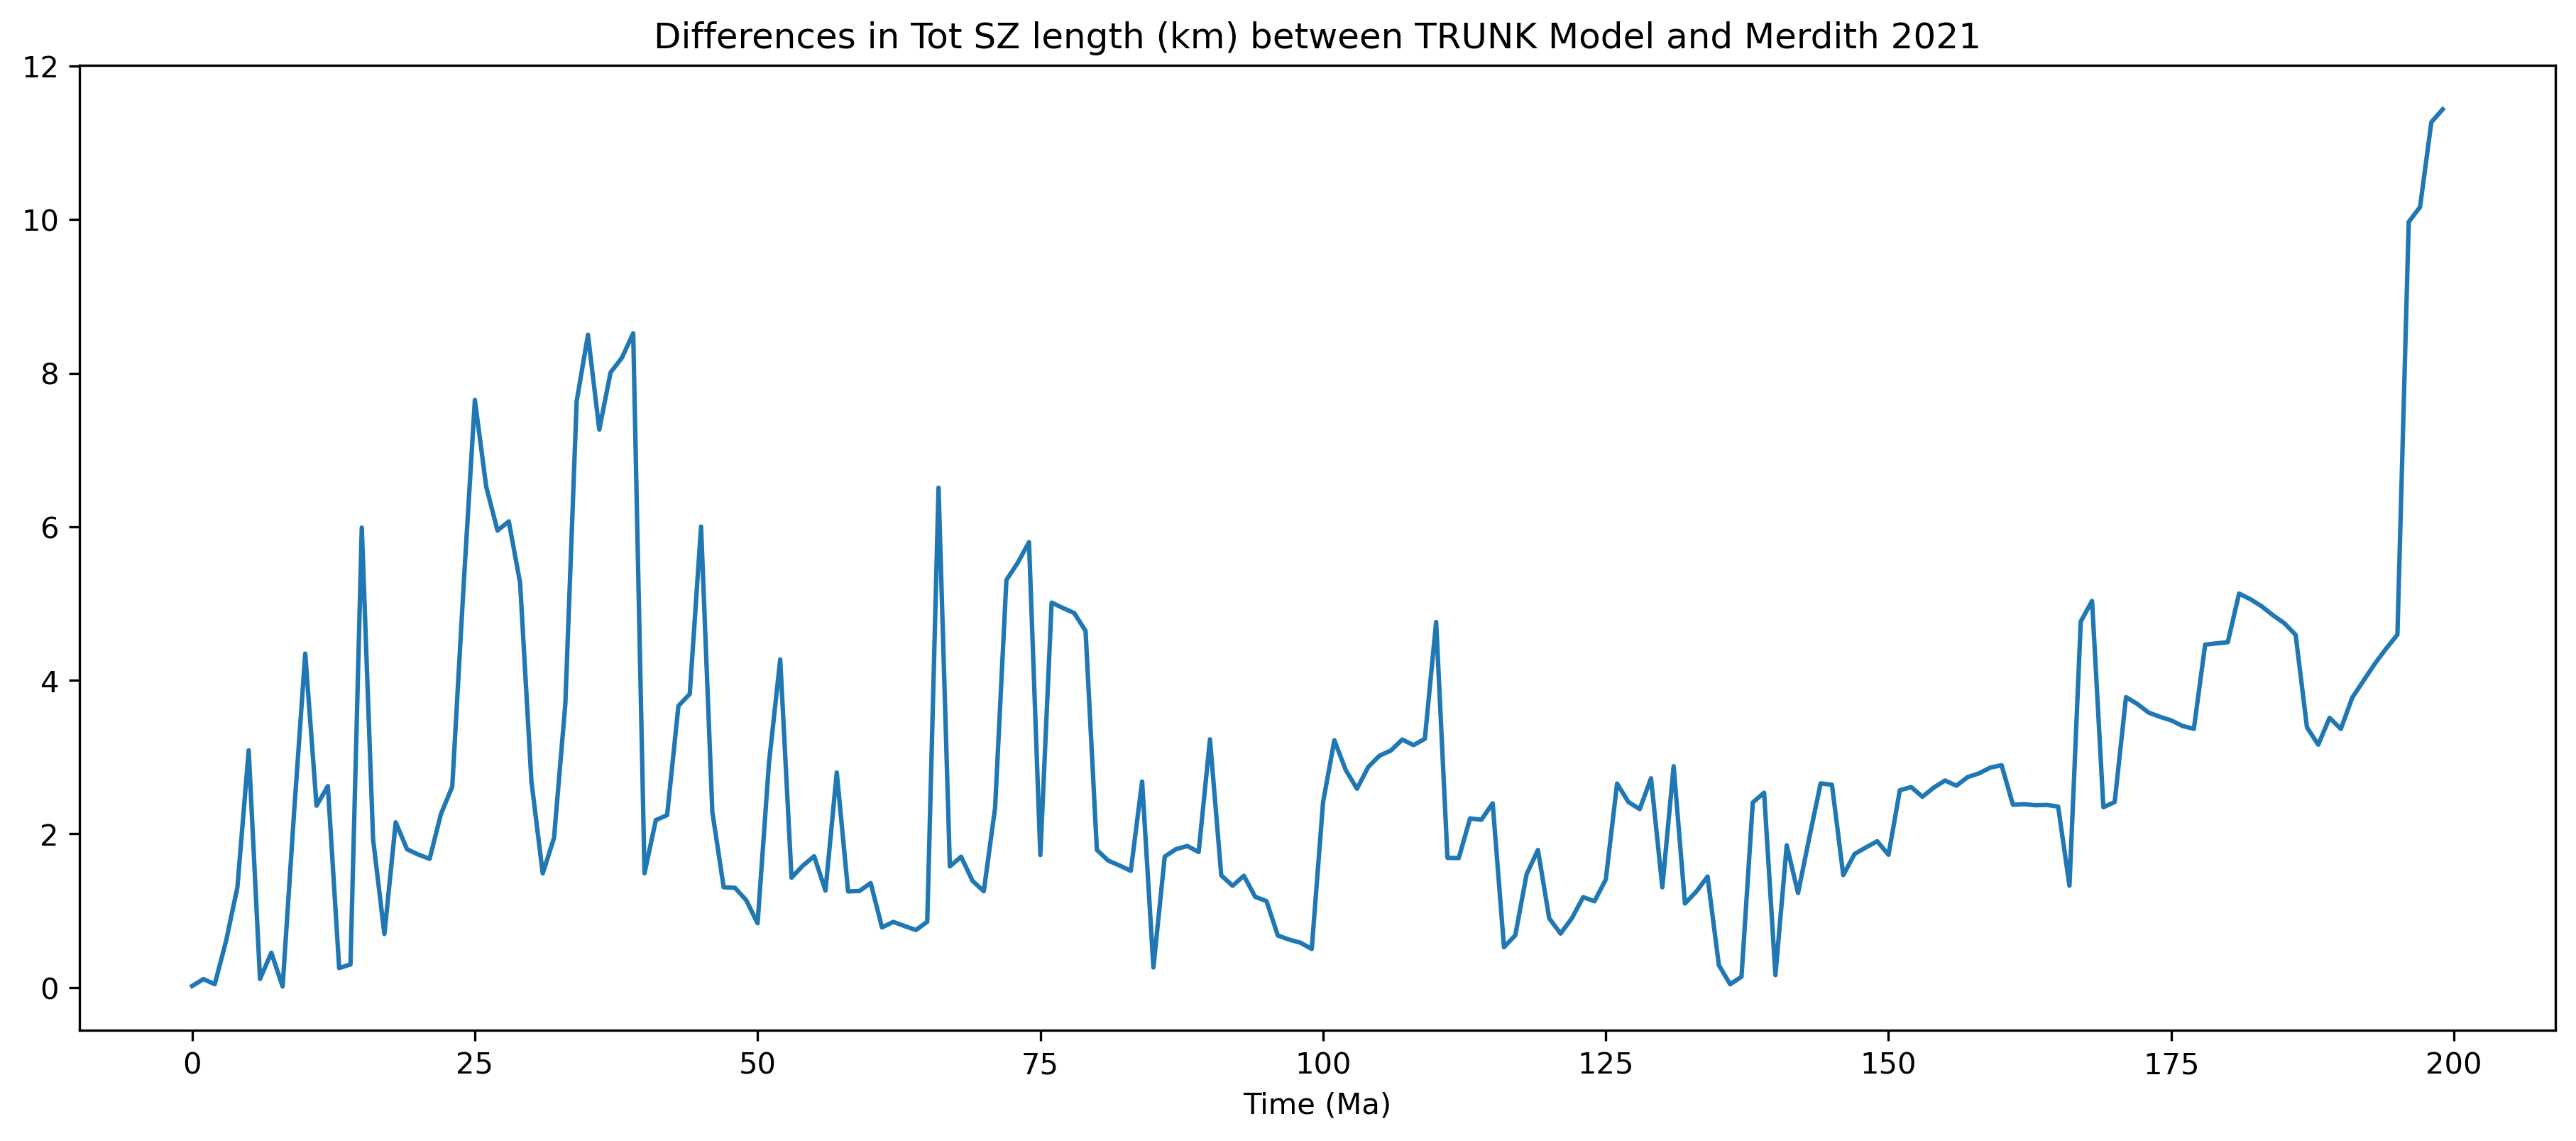

In [301]:
# To refresh... from a couple of cells above:
all_stats = np.array([Muller_stats, TRUNK_stats, Merdith_stats])
model_labels = {"0": "Muller 2019",
               "1" : "TRUNK Model",
               "2" : "Merdith 2021"}

def plot_difference_between_two_models_stats(all_stats, i, min_time, max_time, delta_time=1, save_loc=None):
    """ Plot differences in plate tectonic stats between n plate models. 
    
    Takes a list `all_stats` containing string paths to n plate tectonic stats csv files, finds all possible
    combinations of plate model comparisons, calculates stat differences, and creates n!/(2!(n-2)!) plots; one
    for each combination.
    
    Parameters
    ----------
    all_stats : array
        An array containing paths to n csv files containing plate tectonic stats for n different plate motion models.
    i : int
        An integer from 1-9 to identify which stat to calculate differences of.
    min_time : int
        Starting time to plot from.
    max_time : int
        Last time to plot from.
    delta_time : int, default=1
        Time interval for plotting; by default every 1 Ma.
    save_loc : list of str, default=None
        Optional: a list containing n directories including a filename + filetype extension to save all n plots to.
        
    """
    # A useful index for each of the n!/(2!(n-2)!) plots 
    count = 0
    
    # Calculate all combinations of plate model pairs, loop through them all
    import itertools
    combos = list(itertools.combinations([str(int(index)) for index in np.arange(0,len(all_stats))],2)) 
    for combo in combos:
        plt.figure(figsize=(15, 6), dpi=300)
        combo = [int(float(index)) for index in list(combo)]
        count += 1
        stats1 = all_stats[combo[0]]
        stats2 = all_stats[combo[1]]
        stat_of_model1 = [float(str(stat)) for stat in stats1[i][min_time:max_time:delta_time]]
        stat_of_model2 = [float(str(stat)) for stat in stats2[i][min_time:max_time:delta_time]]
        
        time_to_plot = [int(str(time)) for time in stats[0][min_time:max_time:delta_time]]
        difference = np.absolute(np.subtract(stat_of_model1, stat_of_model2))
        
        plt.plot(time_to_plot, difference)    
        plt.title("Differences in " + plot_properties[str(i)] + " between " + model_labels[str(combo[0])] + 
                                                                                        " and " + 
                model_labels[str(combo[1])]) 
        plt.xlabel("Time (Ma)")
        
        if save_loc is not None:
            plt.savefig(save_loc[count], dpi=300)

        
# Plot the 5th and 1st stats: total subduction zone and MOR length (km) for all three plate models from 0-200Ma
min_time = 0
max_time = 200
indices = [5]
for i in indices:
    plot_difference_between_two_models_stats(all_stats, i, min_time, max_time)

Another plate tectonic stat... take (1) differences in MOR Length (km) among the Muller2019, TRUNK Model and Merdith2021 models. 

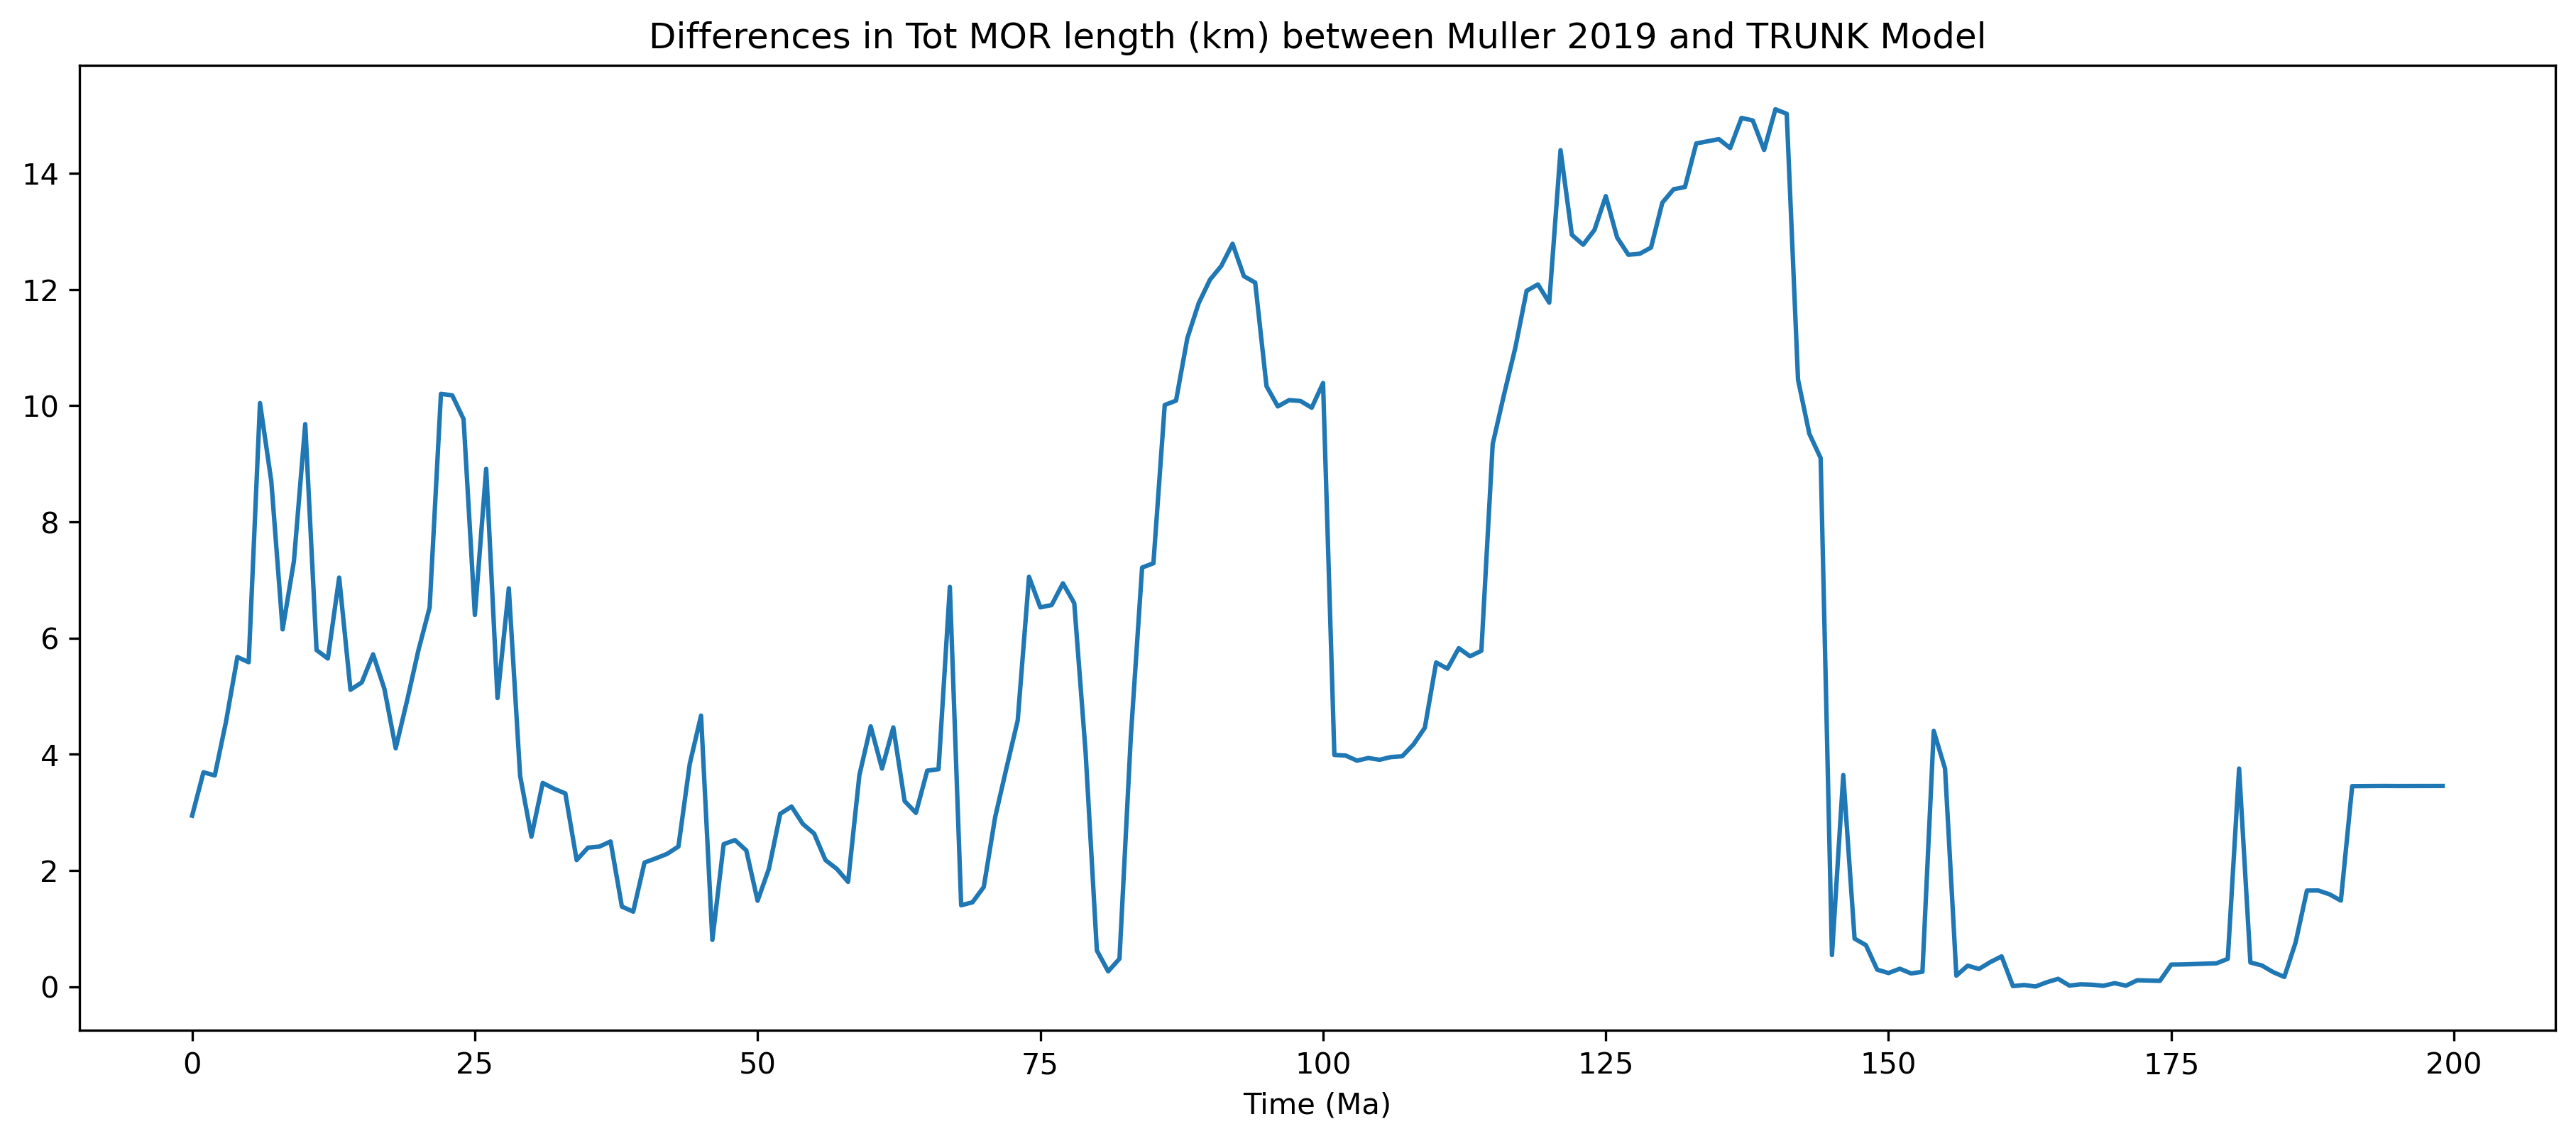

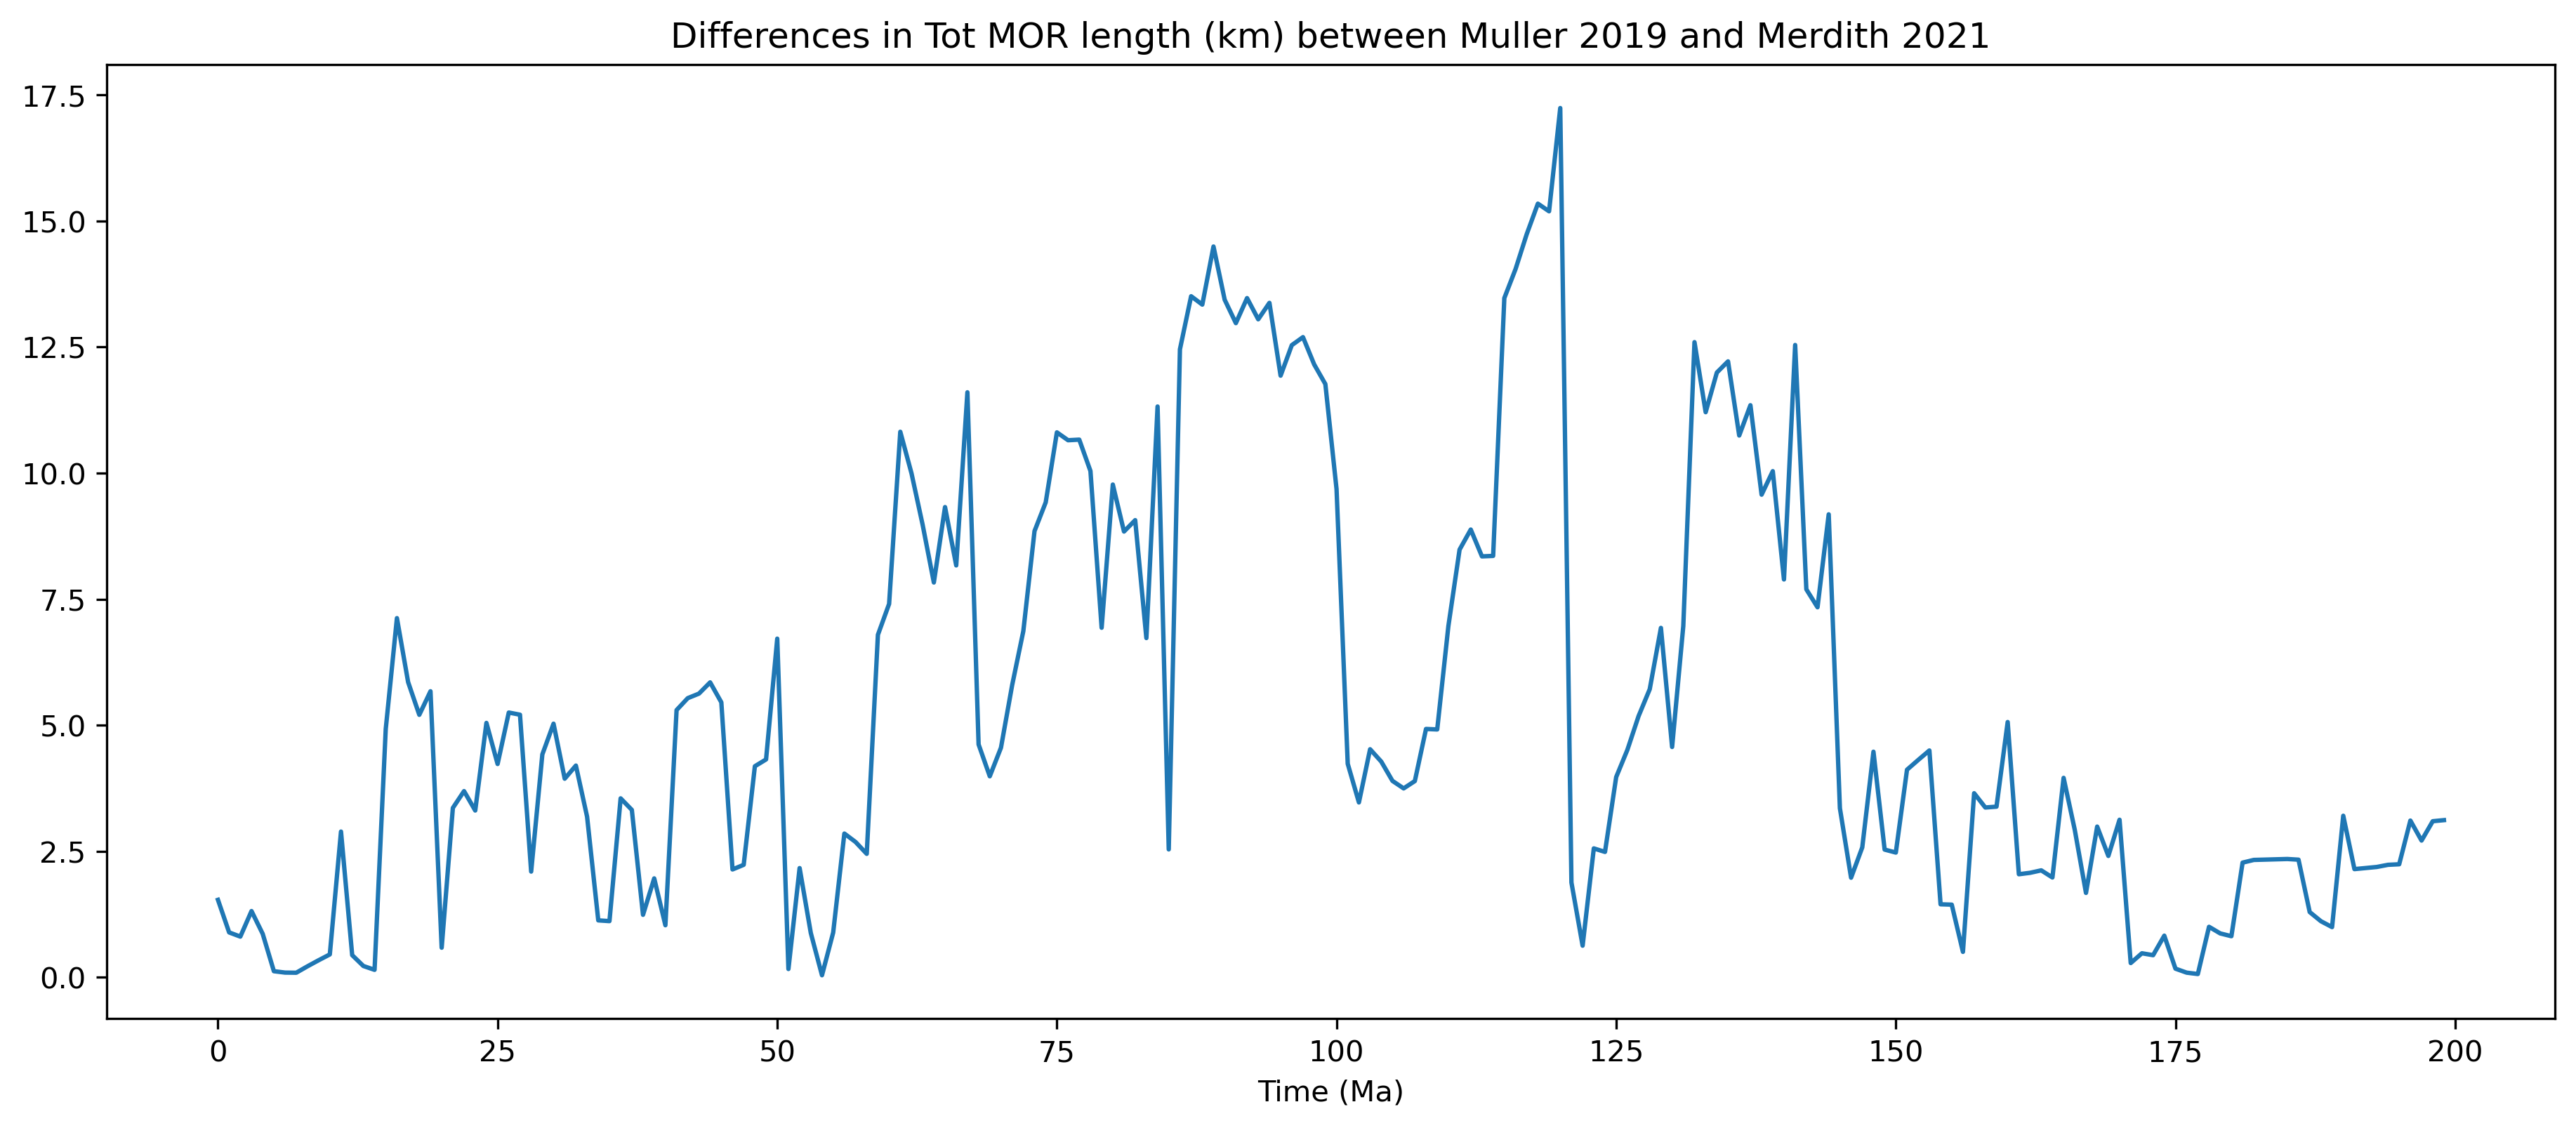

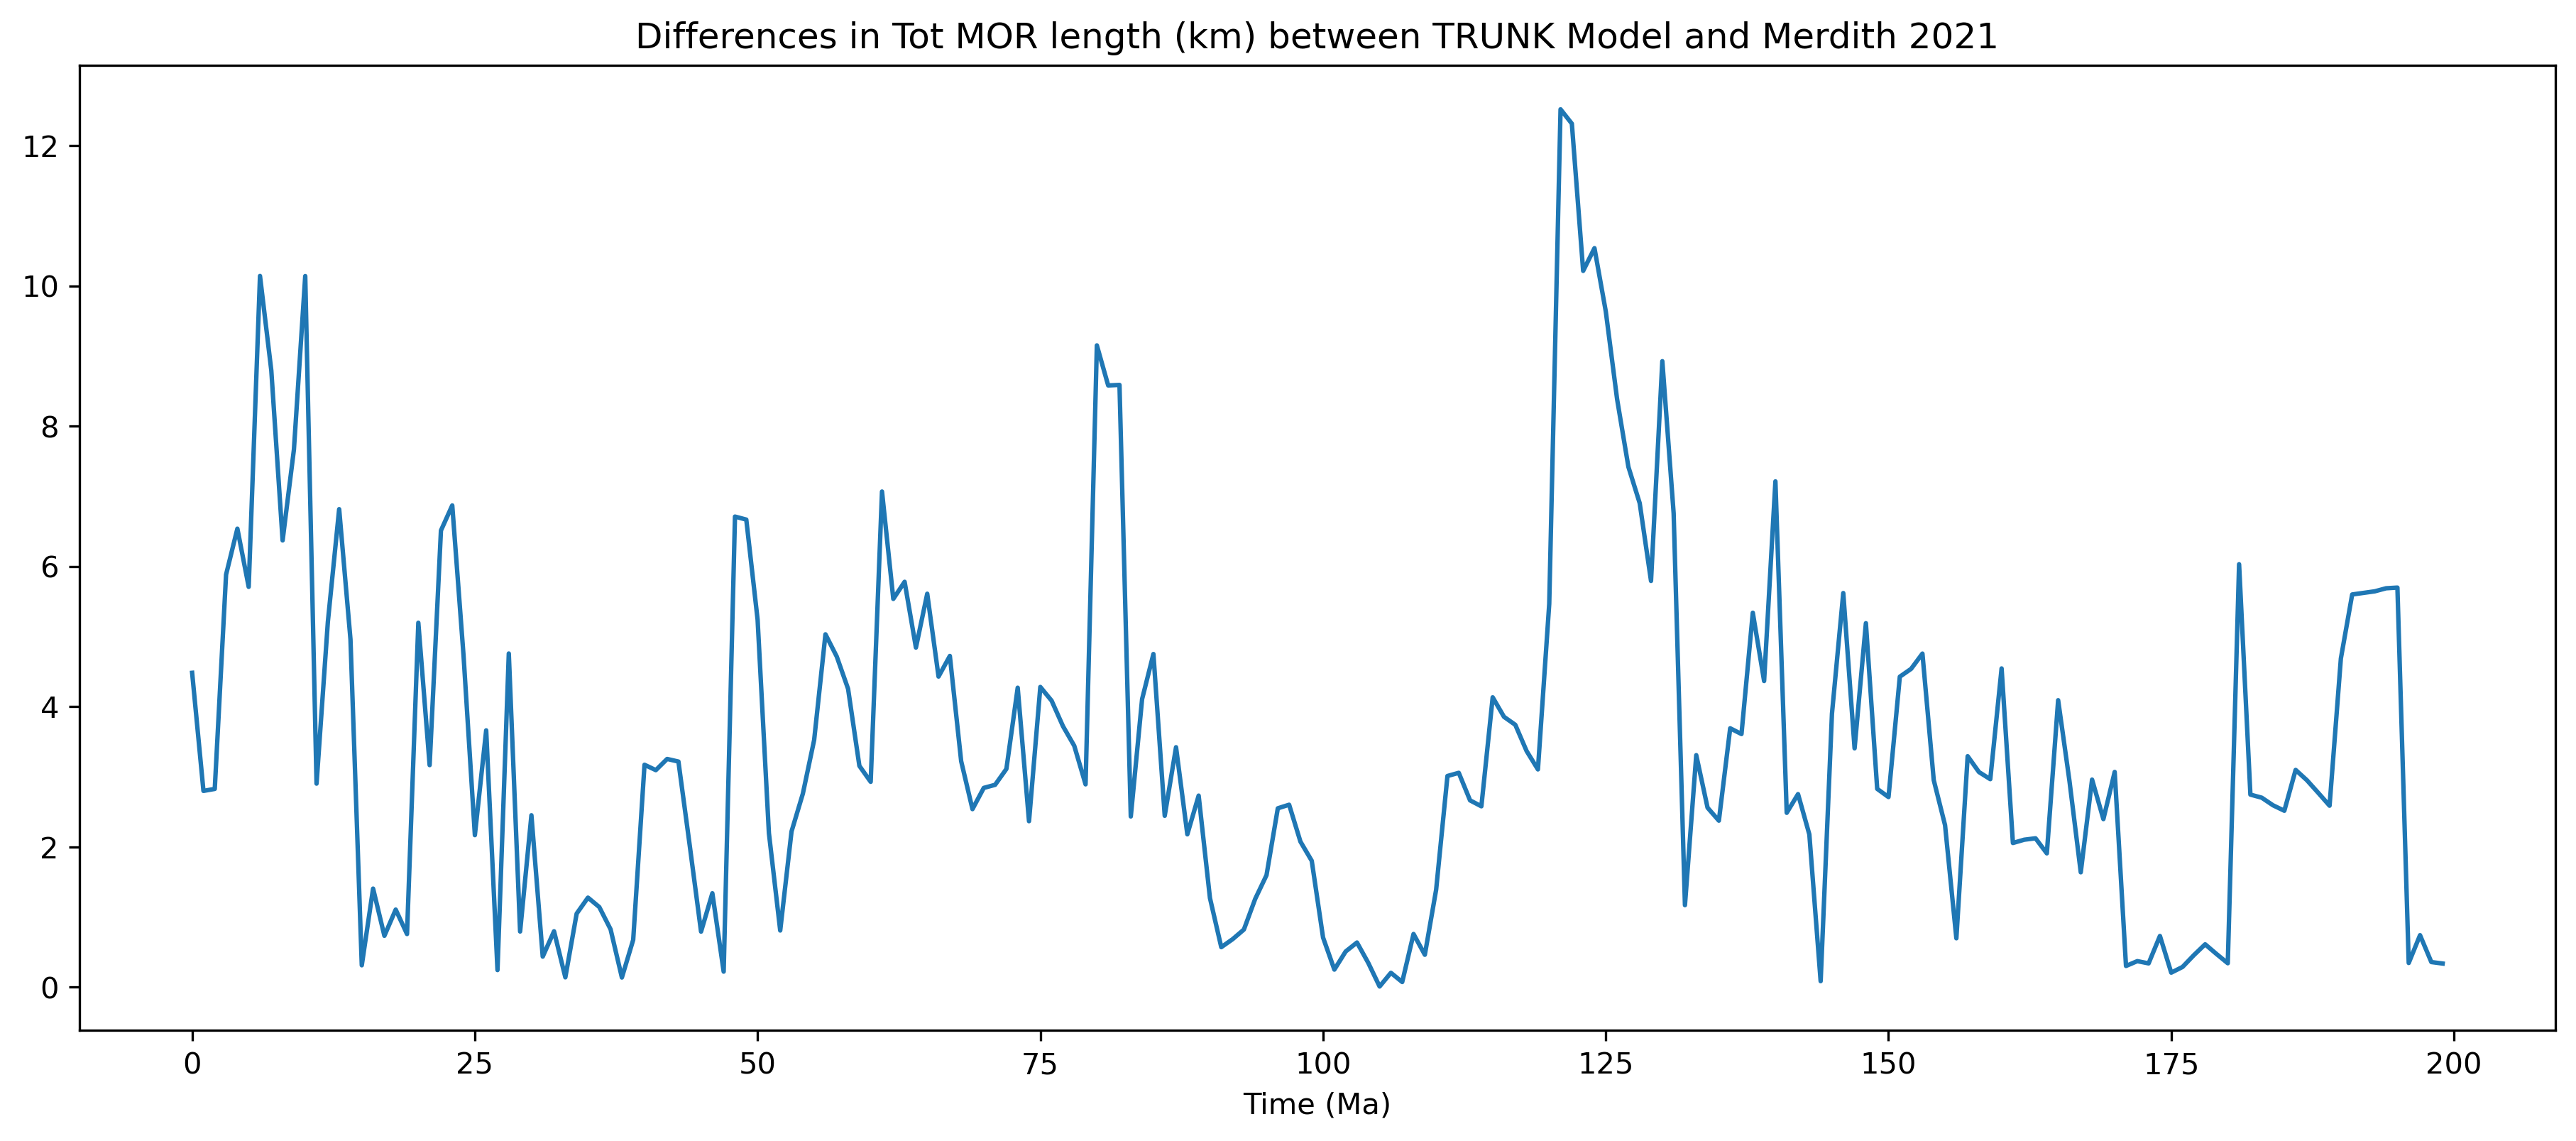

In [303]:
min_time = 0
max_time = 200
indices = [1]
for i in indices:
    plot_difference_between_two_models_stats(all_stats, i, min_time, max_time)